## A. Determining important factors that influence antler mass in male white-tailed deer
## 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
import math as m

from sklearn import linear_model
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xg

C:\Users\wpson\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 2. Dataset description

* These two datasets include data collected from male white-tailed deer from a captive colony at the Kerr Wildlife Management Area.  They include parentage information (i.e., the unique ID of the mother 'DID' and unique ID of the father 'SID', age, birth year, diet type, antler mass, and body mass of male white-tailed deer. 
* Variables: birth weight 'birth wt', mother 'DID', father 'SID', dietary intake 'Energy', birth year 'birthyr', and year data was collected 'yr'.
* The variable 'Energy' is an ordinal variable representing two diets that differed in dietary energy where 'S'= 2.65 kcal/g and 'L'= 1.77 kcal. 

## 3. Project goals: 
* Assess the influence from several factors on antler size male white-tailed deer.

In [2]:
data = pd.read_csv("kerr_data_log.csv")

Text(0.5, 1.0, 'Relationship between Antler Mass and Body Mass')

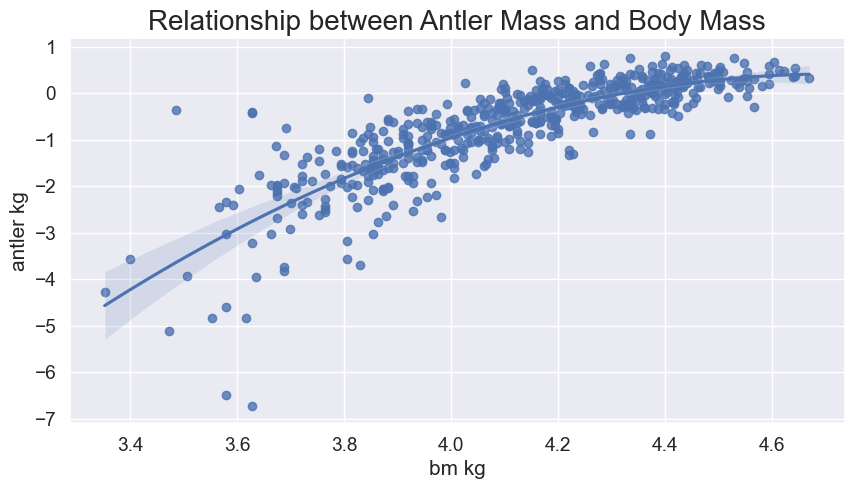

In [3]:
sns.set(rc={"figure.figsize":(10, 5)}, font_scale = 1.25)
sns.regplot(x = 'bm kg', y = 'antler kg', data = data, order=2)
plt.title('Relationship between Antler Mass and Body Mass', fontsize=20)

## 4. Data Cleaning

* The variables 'birthyrcat' will be dropped from all datasets.

In [4]:
data.corr()

C:\Users\wpson\AppData\Local\Temp\ipykernel_22268\2627137660.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,SID,DID,ID,Birthyr,yr,age,antler kg,bm kg
SID,1.000000,0.418005,0.761769,0.770531,0.558518,0.088298,0.021371,0.048027
DID,0.418005,1.000000,0.642825,0.637670,0.419033,0.011714,-0.054531,-0.068624
ID,0.761769,0.642825,1.000000,0.998528,0.688910,0.063696,-0.028864,0.008274
Birthyr,0.770531,0.637670,0.998528,1.000000,0.690531,0.066030,-0.022047,0.013467
yr,0.558518,0.419033,0.688910,0.690531,1.000000,0.765416,0.486653,0.519003
age,0.088298,0.011714,0.063696,0.066030,0.765416,1.000000,0.691649,0.706934
antler kg,0.021371,-0.054531,-0.028864,-0.022047,0.486653,0.691649,1.000000,0.821724
bm kg,0.048027,-0.068624,0.008274,0.013467,0.519003,0.706934,0.821724,1.000000


Age is correlated enough to body mass to warrant dropping it

In [5]:
data.drop(['Birthyrcat','age'],axis=1, inplace=True)

In [6]:
# 'Energy' was encoded with label encoder because it is an ordinal variable.

le = LabelEncoder()

data['Energy'] = le.fit_transform(data['Energy'])

* Segregating the target variable 'antler_kg'

In [7]:
X = data.drop(['antler kg'], axis=1)

y = data['antler kg']

## 5. Modeling the datasets

In [8]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary()) # R2 pretty high.  Good model fit to data.

                            OLS Regression Results                            
Dep. Variable:              antler kg   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     194.3
Date:                Tue, 06 Dec 2022   Prob (F-statistic):          2.07e-144
Time:                        14:16:55   Log-Likelihood:                -470.58
No. Observations:                 560   AIC:                             957.2
Df Residuals:                     552   BIC:                             991.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2031.7663    727.398     -2.793      0.0

In [9]:
pred = est2.predict(X2)
print(pred)

0      1.240308
1      1.134812
2      0.973646
3      1.192689
4      0.690941
         ...   
555   -2.703938
556   -2.530469
557   -2.797382
558   -2.827232
559   -3.104946
Length: 560, dtype: float64


In [10]:
mae = mean_absolute_error(data['antler kg'], pred)
print("mean absolute error for the MLR {}".format(mae))

mean absolute error for the MLR 0.3832729601976916


Contrast results of linear model with a few machine learning models to see if predictors' feature importances vary among fitted and tuned models

In [11]:
rf = RandomForestRegressor(random_state = 1)
gb = GradientBoostingRegressor(random_state = 1)
xgbr = xg.XGBRegressor(random_state = 1)

KFold cross validation to assess overfit

In [12]:
scores_rf = cross_val_score(rf,X,y,scoring="neg_mean_absolute_error",cv=10)
mae_rf = (-scores_rf)
print("MAE values: ", mae_rf)
print("MAE average: ", np.mean(mae_rf))

MAE values:  [0.17867548 0.25694851 0.22260418 0.30147293 0.32762575 0.28902967
 0.33503063 0.4560267  0.44255025 1.00605769]
MAE average:  0.3816021803144464


In [13]:
scores_gb = cross_val_score(gb,X,y,scoring="neg_mean_absolute_error",cv=10)
mae_gb = (-scores_gb)
print("MAE values: ", mae_gb)
print("MAE average: ", np.mean(mae_gb))

MAE values:  [0.18469196 0.24413952 0.17112651 0.2407004  0.25506936 0.24165237
 0.25368609 0.46209143 0.44158339 0.89532647]
MAE average:  0.3390067502707132


In [14]:
scores_xgbr = cross_val_score(xgbr,X,y,scoring="neg_mean_absolute_error",cv=10)
mae_xgbr = (-scores_xgbr)
print("MAE values: ", mae_xgbr)
print("MAE average: ", np.mean(mae_xgbr))

C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

MAE values:  [0.14922751 0.2113519  0.17444573 0.2650473  0.24748262 0.22833463
 0.28409573 0.42346588 0.48673653 1.01561291]
MAE average:  0.3485800739271861


Tune hyperparamters via grid search 

In [15]:
params = [{'n_estimators':np.arange(5,100,5),
           'max_features':np.arange(0.1,1.0,0.05)}]

In [16]:
gs_rf = GridSearchCV(estimator = rf, 
                           param_grid = params,
                           cv=5, 
                           scoring="neg_mean_absolute_error",
                           verbose=1,
                           n_jobs=-1)

In [17]:
gs_gb = GridSearchCV(estimator = gb, 
                           param_grid = params,
                           cv=5, 
                           scoring="neg_mean_absolute_error",
                           verbose=1,
                           n_jobs=-1)

In [18]:
gs_xgbr = GridSearchCV(estimator = xgbr, 
                           param_grid = params,
                           cv=5, 
                           scoring="neg_mean_absolute_error",
                           verbose=1,
                           n_jobs=-1)

In [19]:
gs_rf.fit(X,y)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
             param_grid=[{'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                          'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])}],
             scoring='neg_mean_absolute_error', verbose=1)

In [20]:
pred_rf = gs_rf.predict(X)
mae_gs_rf = mean_absolute_error(y,pred_rf)
print(mae_gs_rf)

0.1279539967820238


In [21]:
gs_gb.fit(X,y)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=1),
             n_jobs=-1,
             param_grid=[{'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                          'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])}],
             scoring='neg_mean_absolute_error', verbose=1)

In [22]:
pred_gb = gs_gb.predict(X)
mae_gs_gb = mean_absolute_error(y,pred_gb)
print(mae_gs_gb) 

0.21006011610648787


In [23]:
gs_xgbr.fit(X,y)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits


C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:19:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid=[{'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                          'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])}],
             scoring='neg_mean_absolute_error', verbose=1)

In [24]:
pred_xgbr = gs_xgbr.predict(X)
mae_gs_xgbr = mean_absolute_error(y,pred_xgbr)
print(mae_gs_xgbr) # lowest mae after tuning hyperparameters of ML models

0.030529641784494632


Assess if predictors have similar feature importance scores among models

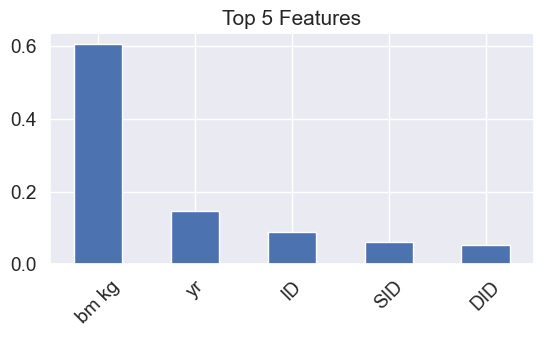

In [25]:
feat_importances = pd.Series(gs_rf.best_estimator_.feature_importances_, index=X.columns)
plt.figure(figsize=(6.25, 3))
feat_importances.nlargest(5).plot(kind='bar')
titlefont = 15
plt.title("Top 5 Features", fontdict={'fontsize':titlefont})
plt.xticks(rotation = 45)
plt.show()

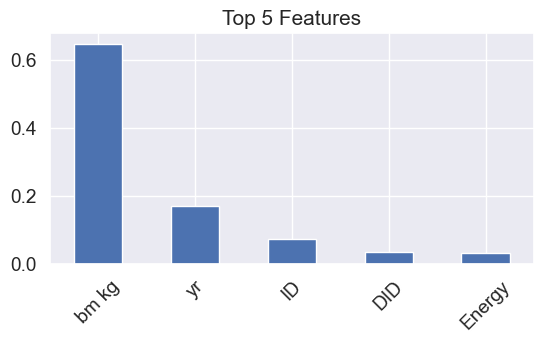

In [26]:
feat_importances = pd.Series(gs_gb.best_estimator_.feature_importances_, index=X.columns)
plt.figure(figsize=(6.25, 3))
feat_importances.nlargest(5).plot(kind='bar')
titlefont = 15
plt.title("Top 5 Features", fontdict={'fontsize':titlefont})
plt.xticks(rotation = 45) 
plt.show()

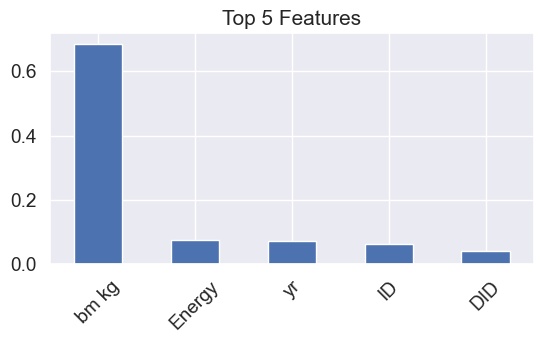

In [27]:
feat_importances = pd.Series(gs_xgbr.best_estimator_.feature_importances_, index=X.columns)
plt.figure(figsize=(6.25, 3))
feat_importances.nlargest(5).plot(kind='bar')
titlefont = 15
plt.title("Top 5 Features", fontdict={'fontsize':titlefont})
plt.xticks(rotation = 45) 
plt.show()

All ML models found that bm kg was very important in predicting antler mass. The extreme boosting regressor model found that energy was the second most important feature, although it's importance was still a great deal less than body mass.  